In [ ]:
# Create the Spark Session
from pyspark.sql import SparkSession

spark = (
    SparkSession 
    .builder 
    .appName("Streaming from Kafka") 
    .config("spark.streaming.stopGracefullyOnShutdown", True) 
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0')
    .config("spark.sql.shuffle.partitions", 4)
    .master("local[*]") 
    .getOrCreate()
)

In [2]:
spark

In [3]:
# Create the kafka_df to read from kafka

kafka_df = (
    spark
    .readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", "ed-kafka:29092")
    .option("subscribe", "twitter")
    .option("startingOffsets", "earliest")
    .load()
)

In [4]:
# View schema for raw kafka_df
kafka_df.printSchema()
# kafka_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
# Parse value from binay to string into kafka_json_df
from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))

In [6]:
# View schema for raw kafka_json_df
kafka_json_df.printSchema()
# kafka_json_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [7]:
# Schema of the Pyaload

from pyspark.sql.types import StringType, StructField, StructType, ArrayType, LongType

json_schema = (
    StructType(
    [
        StructField('tweet', StringType(), True)
    ])
)

In [8]:
# Apply the schema to payload to read the data
from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")

In [9]:
# To the schema of the data, place a sample json file and change readStream to read 
streaming_df.printSchema()
# streaming_df.show(truncate=False)

root
 |-- tweet: string (nullable = true)



In [11]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

In [12]:
# Initialize a list to store the sentiments
sentiment_list = []

In [15]:
# Function to perform sentiment analysis and update the graph
def process_and_visualize(df, epoch_id):
    global sentiment_list
    
    # Convert Spark DataFrame to Pandas
    pandas_df = df.toPandas()
    
    # Perform sentiment analysis
    for tweet in pandas_df['tweet']:
        analysis = TextBlob(tweet)
        sentiment = analysis.sentiment.polarity  # Get sentiment polarity (-1 to 1)
        sentiment_list.append(sentiment)

    # Create a DataFrame for plotting
    sentiment_df = pd.DataFrame(sentiment_list, columns=['Sentiment'])
    
    # Assign colors based on sentiment values
    colors = ['blue' if sentiment > 0 else 'red' if sentiment < 0 else 'yellow' for sentiment in sentiment_list]

    # Plot the sentiments
    # plt.clf()  # Clear the previous plot
    clear_output(wait=True)
    # sentiment_df.plot(kind='line', ylim=(-1, 1), title="Real-Time Tweet Sentiment")
    plt.subplot(1, 2, 1)  # First subplot for scatter plot
    plt.scatter(range(len(sentiment_list)), sentiment_list, color=colors, label='Sentiment')
    plt.ylim(-1, 1)
    plt.axhline(y=0, color='black', linestyle='--')  # Line for neutral sentiment
    plt.xlabel("Number Of Tweets")
    plt.ylabel("Sentiment")
    plt.title("Real-Time Tweet Sentiment Analysis")
    
    # Calculate sentiment distribution for bar chart
    positive = sum(1 for sentiment in sentiment_list if sentiment > 0)
    negative = sum(1 for sentiment in sentiment_list if sentiment < 0)
    neutral = sum(1 for sentiment in sentiment_list if sentiment == 0)

    total = len(sentiment_list) if len(sentiment_list) > 0 else 1  # Avoid division by zero
    positive_pct = (positive / total) * 100
    negative_pct = (negative / total) * 100
    neutral_pct = (neutral / total) * 100

    # Data for bar chart
    sentiment_categories = ['Positive', 'Negative', 'Neutral']
    sentiment_counts = [positive_pct, negative_pct, neutral_pct]
    bar_colors = ['blue', 'red', 'yellow']

    # Plot the bar chart
    plt.subplot(1, 2, 2)  # Second subplot for bar chart
    bars = plt.bar(sentiment_categories, sentiment_counts, color=bar_colors)
    plt.ylim(0, 100)
    plt.ylabel("Percentage Of Tweets (%)")
    plt.title("Sentiment Distribution")

    # Add percentage labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout so both plots fit   
    
    plt.pause(0.1)  # Pause to update the graph dynamically

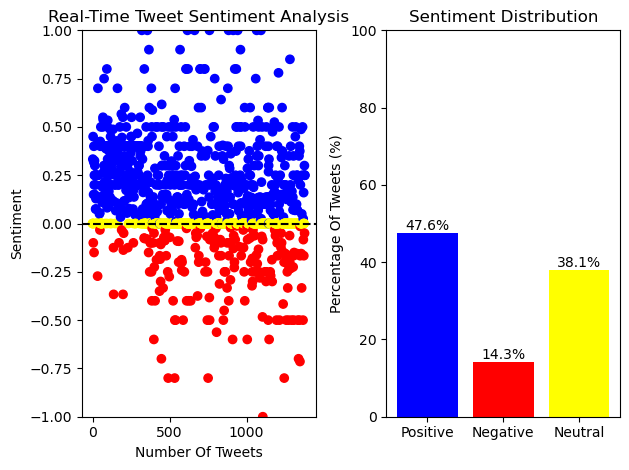

In [ ]:
query = (
    streaming_df
    .writeStream
    .foreachBatch(process_and_visualize)
    .outputMode("append")
    .option("checkpointLocation", "checkpoint_dir_kafka")
    .start()
)

# Show the plot
plt.ion()  # Enable interactive mode
plt.show()

query.awaitTermination()